<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/NMACN2022/projects/modelingsteps/TrainIllusionDataProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMACN2022/projects/modelingsteps/TrainIllusionDataProject.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Example Data Project: the Train Illusion

Marius 't Hart, Megan Peters, Paul Schrater, Jean Laurens, Gunnar Blohm

**Disclaimer**:  this is a "toy" data neuroscience project used to demonstrate the [10 step procedure of how-to-model](https://doi.org/10.1523/ENEURO.0352-19.2019). It is not meant to be state of the art research.

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Setup

In [ ]:
# @title Install dependencies
!pip install tqdm --quiet

In [ ]:
# Imports

# for matrices and plotting
import numpy as np
import matplotlib.pyplot as plt

# for random distributions
from scipy.stats import norm, poisson

# for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
# @title Helper functions
# @markdown Generate the Data


def generateSpikeTrains():

  gain = 2
  neurons = 50
  movements = [0, 1, 2]
  repetitions = 800

  np.random.seed(37)

  # set up the basic parameters:
  dt = 1/100
  start, stop = -1.5, 1.5
  t = np.arange(start, stop + dt, dt)  # a time interval
  Velocity_sigma = 0.5  # std dev of the velocity profile
  Velocity_Profile = norm.pdf(t, 0, Velocity_sigma)/norm.pdf(0, 0, Velocity_sigma)  # The Gaussian velocity profile, normalized to a peak of 1

  # set up the neuron properties:
  Gains = np.random.rand(neurons) * gain  # random sensitivity between 0 and `gain`
  FRs = (np.random.rand(neurons) * 60 ) - 10  # random base firing rate between -10 and 50

  # output matrix will have this shape:
  target_shape = [len(movements), repetitions, neurons, len(Velocity_Profile)]

  # build matrix for spikes, first, they depend on the velocity profile:
  Spikes = np.repeat(Velocity_Profile.reshape([1, 1, 1, len(Velocity_Profile)]),
                     len(movements)*repetitions*neurons, axis=2).reshape(target_shape)

  # multiplied by gains:
  S_gains = np.repeat(np.repeat(Gains.reshape([1, 1, neurons]),
                                len(movements)*repetitions, axis=1).reshape(target_shape[:3]),
                      len(Velocity_Profile)).reshape(target_shape)
  Spikes = Spikes * S_gains

  # and multiplied by the movement:
  S_moves = np.repeat( np.array(movements).reshape([len(movements), 1, 1, 1]),
                      repetitions*neurons*len(Velocity_Profile), axis=3 ).reshape(target_shape)
  Spikes = Spikes * S_moves

  # on top of a baseline firing rate:
  S_FR = np.repeat(np.repeat(FRs.reshape([1, 1, neurons]), len(movements)*repetitions, axis=1).reshape(target_shape[:3]),
                   len(Velocity_Profile)).reshape(target_shape)
  Spikes = Spikes + S_FR

  # can not run the poisson random number generator on input lower than 0:
  Spikes = np.where(Spikes < 0, 0, Spikes)

  # so far, these were expected firing rates per second, correct for dt:
  Spikes = poisson.rvs(Spikes * dt)

  return Spikes


def subsetPerception(spikes):

  movements = [0, 1, 2]
  split = 400
  subset = 40
  hwin = 3

  [num_movements, repetitions, neurons, timepoints] = np.shape(spikes)

  decision = np.zeros([num_movements, repetitions])

  # ground truth for logistic regression:
  y_train = np.repeat([0, 1, 1], split)
  y_test = np.repeat([0, 1, 1], repetitions - split)

  m_train = np.repeat(movements, split)
  m_test = np.repeat(movements, split)

  # reproduce the time points:
  dt = 1/100
  start, stop = -1.5, 1.5
  t = np.arange(start, stop + dt, dt)

  w_idx = list((abs(t) < (hwin*dt)).nonzero()[0])
  w_0 = min(w_idx)
  w_1 = max(w_idx) + 1  # python...

  # get the total spike counts from stationary and movement trials:
  spikes_stat = np.sum( spikes[0, :, :, :], axis=2)
  spikes_move = np.sum( spikes[1:, :, :, :], axis=3)

  train_spikes_stat = spikes_stat[:split, :]
  train_spikes_move = spikes_move[:, :split, :].reshape([-1, neurons])

  test_spikes_stat = spikes_stat[split:, :]
  test_spikes_move = spikes_move[:, split:, :].reshape([-1, neurons])

  # data to use to predict y:
  x_train = np.concatenate((train_spikes_stat, train_spikes_move))
  x_test = np.concatenate((test_spikes_stat, test_spikes_move))

  # this line creates a logistics regression model object, and immediately fits it:
  population_model = LogisticRegression(solver='liblinear',
                                        random_state=0).fit(x_train, y_train)

  # solver, one of: 'liblinear', 'newton-cg', 'lbfgs', 'sag', and 'saga'
  # some of those require certain other options
  #print(population_model.coef_)       # slope
  #print(population_model.intercept_)  # intercept

  ground_truth = np.array(population_model.predict(x_test))
  ground_truth = ground_truth.reshape([3, -1])

  output = {}
  output['perception'] = ground_truth
  output['spikes'] = spikes[:, split:, :subset, :]

  return output


def getData():

  spikes = generateSpikeTrains()

  dataset = subsetPerception(spikes=spikes)

  return dataset


dataset = getData()
perception = dataset['perception']
spikes = dataset['spikes']

In [ ]:
# @title Plot Functions

def rasterplot(spikes,movement,trial):

  [movements, trials, neurons, timepoints] = np.shape(spikes)
  trial_spikes = spikes[movement,trial, :, :]
  trial_events = [((trial_spikes[x, :] > 0).nonzero()[0] - 150)/100 for x in range(neurons)]
  dt = 1/100

  plt.figure()
  plt.eventplot(trial_events, linewidths=1);
  plt.title('movement: %d - trial: %d'%(movement, trial))
  plt.ylabel('neuron')
  plt.xlabel('time [s]')


def plotCrossValAccuracies(accuracies):
  f, ax = plt.subplots(figsize=(8, 3))
  ax.boxplot(accuracies, vert=False, widths=.7)
  ax.scatter(accuracies, np.ones(8))
  ax.set(
    xlabel="Accuracy",
    yticks=[],
    title=f"Average test accuracy: {accuracies.mean():.2%}"
  )
  ax.spines["left"].set_visible(False)

----
# Phenomenon
*Part of Steps 1-2*

The train illusion occurs when sitting on a train and viewing another train outside the window. Suddenly, the other train *seems* to move, i.e. you experience visual motion of the other train relative to your train. But which train is actually moving?

Often people mix this up. In particular, they think their own train might be moving when it's the other train that moves; or vice versa. The illusion is usually resolved once you gain vision of the surroundings that lets you disambiguate the relative motion; or if you experience strong vibrations indicating that it is indeed your own train that is in motion.

----
# Question

*Part of Step 1*

We assume that we have build the train illusion model (see the other example project colab). That model predicts that accumulated sensory evidence from vestibular signals determines the decision of whether self-motion is experienced or not. We now have vestibular neuron data (simulated in our case, but let's pretend) and would like to see if that prediction holds true.

The data contains $N$ neurons and $M$ trials for each of 3 motion conditions: no self-motion, slowly accelerating self-motion and faster accelerating self-motion. 

\begin{align}
N &= 40\\
M &= 400\\
\end{align}

**So we can ask the following question**: "Does accumulated vestibular neuron activity correlate with self-motion judgements?"

# Background

_Part of step 2_

While it seems a well-known fact that vestibular signals are noisy, we should check if we can also find this in the literature.

Let's also see what's in our data, there should be a 4d array called `spikes` that has spike counts (positive integers), a 2d array called `perception` with self-motion judgements (0=no motion or 1=motion). Let's see what this data looks like:

In [ ]:
print(np.shape(spikes))
print(np.shape(perception))
print(np.mean(perception, axis=1))

(3, 400, 40, 301)
(3, 400)
[0.355  0.7575 0.975 ]


In the `spikes` array, we see our 3 acceleration conditions (first dimension), with 400 trials each (second dimensions) and simultaneous recordings from 40 neurons (third dimension), across 3 seconds in 10 ms bins (fourth dimension). The first two dimensions are also there in the `perception` array.

Perfect perception would have looked like [0, 1, 1]. The average judgements are far from correct (lots of self-motion illusions) but they do make some sense: it's closer to 0 in the no-motion condition and closer to 1 in both of the real-motion conditions.

The idea of our project is that the vestibular signals are noisy so that they might be mis-interpreted by the brain. Let's see if we can reproduce the stimuli from the data:

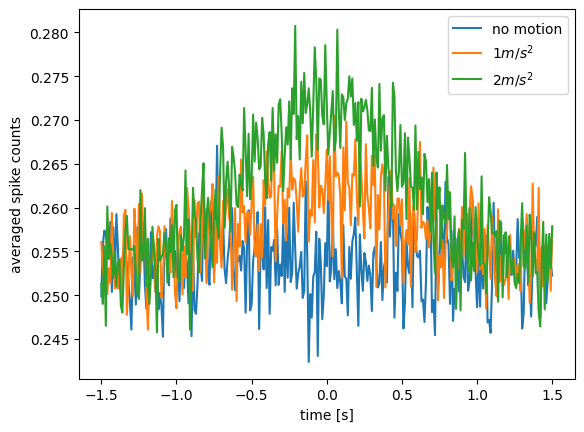

In [ ]:
for move_no in range(3):
  plt.plot(np.arange(-1.5, 1.5 + (1/100),
                     (1/100)),
           np.mean(np.mean(spikes[move_no, :, :, :], axis=0), axis=0),
           label=['no motion', '$1 m/s^2$', '$2 m/s^2$'][move_no])
plt.xlabel('time [s]');
plt.ylabel('averaged spike counts');
plt.legend()
plt.show()

Blue is the no-motion condition, and produces flat average spike counts across the 3 s time interval. The orange and green line do show a bell-shaped curve that corresponds to the acceleration profile. But there also seems to be considerable noise: exactly what we need. Let's see what the spike trains for a single trial look like:

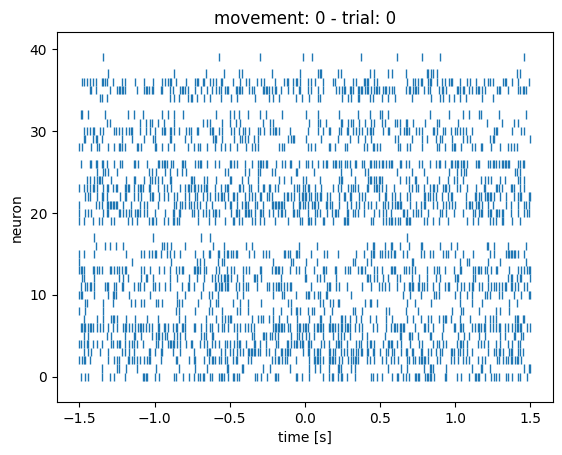

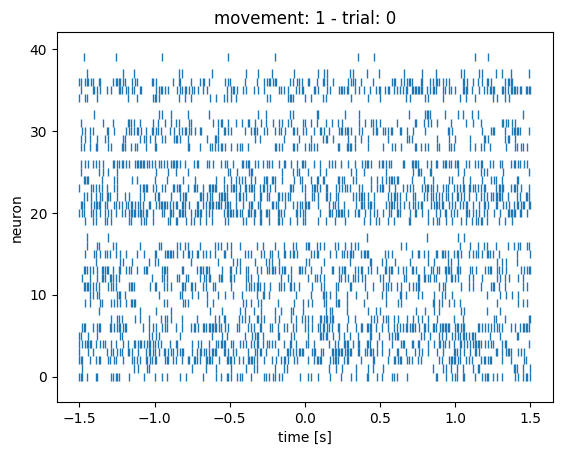

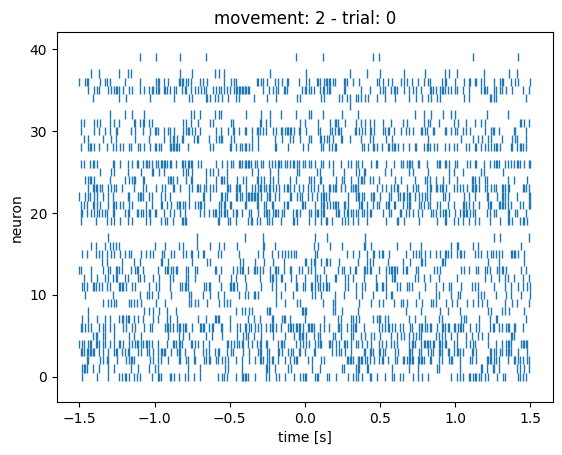

In [ ]:
for move in range(3):
  rasterplot(spikes=spikes, movement=move, trial=0)

You can change the trial number in the bit of code above to compare what the rasterplots look like in different trials. You'll notice that they all look kind of the same: the 3 conditions are very hard (impossible?) to distinguish by eye-balling.

Now that we have seen the data, let's see if we can extract self-motion judgements from the spike counts.

----
# Ingredients

*Part of step 3*

In order to address our question we need to design an appropriate computational data analysis pipeline. We did some brainstorming and think that we need to somehow extract the self-motion judgements from the spike counts of our neurons. Based on that, our algorithm needs to make a decision: was there self motion or not? This is a classical 2-choice classification problem. We will have to transform the raw spike data into the right input for the algorithm (spike pre-processing).

So we determined that we probably needed the following ingredients:

* spike trains $S$ of 3-second trials (10ms spike bins)
* ground truth movement $m_r$ (real) and perceived movement $m_p$
* some form of classifier $C$ giving us a classification $c$
* spike pre-processing

----
# Hypotheses

*Part of step 4*

We think that noise in the signal drives whether or not people perceive self motion. Maybe the brain uses the strongest signal at peak acceleration to decide on self motion, but we actually think it is better to accumulate evidence over some period of time. We want to test this. The noise idea also means that when the signal-to-noise ratio is higher, the brain does better, and this would be in the faster acceleration condition. We want to test this too.

We came up with the following hypotheses focussing on specific details of our overall research question:

* Hyp 1: Accumulated vestibular spike rates explain self-motion judgements better than average spike rates around peak acceleration.
* Hyp 2: Classification performance should be better for faster vs slower self-motion.

> There are many other hypotheses you could come up with, but for simplicity, let's go with those.

Mathematically, we can write our hypotheses as follows (using our above ingredients):
* Hyp 1: $\mathbb{E}[c_{accum}]>\mathbb{E}[c_{win}]$
* Hyp 2: $\mathbb{E}[c_{fast}]>\mathbb{E}[c_{slow}]$

Where $\mathbb{E}[\cdot]$ denotes the expected value (in this case the mean) of its argument, i.e., classification outcome in a given trial type.

----
# Selected toolkit

*Part of step 5*

We want to build some form of classification pipeline. There are many options here, but a simple decoder would be a good start. Since we will learn all about Generalized Linear Models soon, we decided to use that! From W1D4: Generalized Linear Models there were two models that looked relevant:

* Linear-Nonlinear-Poisson GLM: predict spike counts from stimulus
* Logistic Regression: predict stimulus from spike counts

Here we want to predict self-motion from spike counts, so we pick Logistic Regression.

----
# Model draft

*Part of step 6*

Brainstorming on the whiteboard, we came up with this set of steps:

1. convert spike count data into design matrix: trials x neurons (with accumulated or windowed data)
2. get the classes each trial belongs to: stimulus (stationary / moving) or self-motion judgements (moving or not?) as a vector array
3. split data into train and test sets (200 trials each for the 3 conditions?) with an equal number of each class
4. fit logistic regression model on training set, and get predictions for test set

<p align='center'><img src='https://github.com/NeuromatchAcademy/course-content/blob/NMACN2022/tutorials/static/data_analysis_step6.jpeg?raw=True'/></p>



----
# Model implementation

*Part of step 7*



Below is a function that gets us the design matrix of observations X features (in this case: trials X neurons). It sums all spike counts, either across the whole time interval, or a window, specified in seconds before and after the peak acceleration at time=0 (it is the half-width of the window: `halfwin`).

In [ ]:
m_r = np.repeat([0, 1, 1], 400)
m_p = perception.reshape([-1])
a_r = np.repeat([0, 1, 2], 400)  # for grouping in cross validation? maybe not


def getDesignMatrix(spikes, motions, classes, halfwin=None):
  """
    Get the design matrix and vector of classes for a logistic regression.

    Args:
        spikes (numpy.ndarray): a 4d matrix with spike counts for 1) three motion
        conditions, 2) 400 trials, 3) 40 neurons, 4) 301 time bins
        motions (list): motion conditions to include, any subset of [0,1,2]
        classes (list): list of length 3 * 400 with classes to use for the
        logistic regression
        halfwin (None or float): None to use the whole 3 s time interval, or a
        value between 0 and 1.5 seconds as the extent of the window from 0 (when
        acceleration peaks) in both directions.

    Returns:
        (list of numpy.ndarray): first element of the list is the design matrix
        of shape [trials] X [neurons], second elements is a 1d matrix to use as
        a vector of classes to predict from the design matrix

    This function can be used to get the right design matrix and set of class
    labels for a variety of logistic regressions we might want to do.
  """

  # select motion conditions:
  spikes = spikes[motions, :, :, :]
  y = (np.array(classes).reshape([3, -1])[motions, :]).reshape([-1])

  [movstims, trials, neurons, timepoints] = np.shape(spikes)

  # first we get the window (if any):
  if halfwin is None:
    return [np.sum(spikes, axis=3).reshape([movstims*trials, neurons]), y]
  else:
    dt = 1/100
    t = np.arange(-1.5,1.5+dt,dt)
    win_idx = (abs(t) < halfwin).nonzero()[0]
    w_0, w_1 = min(win_idx), max(win_idx)+1
    return [np.sum(spikes[:, :, :, w_0:w_1], axis=3).reshape([movstims*trials, neurons]), y]


# test the function:
[desmat, y] = getDesignMatrix(spikes, motions=[0,1], classes=m_r)
# let's check the shape:
print(np.shape(desmat))
# and let's check if the mean sum of spikes checks out:
print(np.mean(np.sum(spikes, axis=3),axis=(1, 2)))
for mov in range(2):
  print(np.mean(desmat[(mov*400):((mov+1)*400), :]))

(800, 40)
[76.33475 77.53275 78.61975]
76.33475
77.53275


First, the design matrix: `desmat` has the right shape: 800 trials (for two conditions), by 40 neurons.

We also get the same average spike counts from our function (76.3 and 77.5) as when calculating it 'by hand' ([76.33475 77.53275 78.61975]).

This means our function `getDesignMatrix()` works correctly (unit test).

It also gets us the classes for each trial. We can use both judgements, $m_p$, and stimuli, $m_r$, as one vector, and `getDesignMatrix()` returns the correct subset (depending on which motion conditions are used) as the second variable.

We wanted to split the data into a training and test set, but we can have scikit-learn do this for us with the `cross_val_score()` function, as we saw in the GLM day:

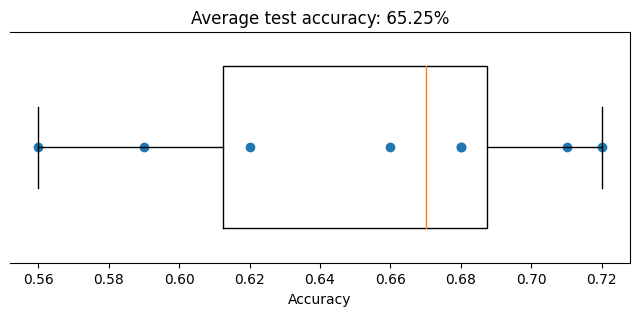

In [ ]:
accuracies = cross_val_score(LogisticRegression(solver='liblinear'), X=desmat, y=y, cv=8)
plotCrossValAccuracies(accuracies) # this plotting function is copied from W1D4: Generalized Linear Models

We asked for 8 cross validations, which show up as the blue dots in the graph (two have the same accuracy). Prediction accuracy ranges from 56% to 72%, with the average at 65%, and the orange line is the median. Given the noisy data, that is not too bad actually.

But maybe it's better to split it according to the conditions where there is motion but of different magnitude. It should work better to classify higher acceleration motion from no motion as compared to classifying the lower acceleration motion.

Maybe it also works better to ignore some of the noise at the beginning and end of each trial by focussing on the spikes around the maximum acceleration, using our window option. The average spike count plot above, seems to best discriminate between the three motion conditions around peak acceleration (at 0 s).

We also want to test if it's possible to predict the self-motion judgements rather than the actual motion.

So we write a function that brings it all together:

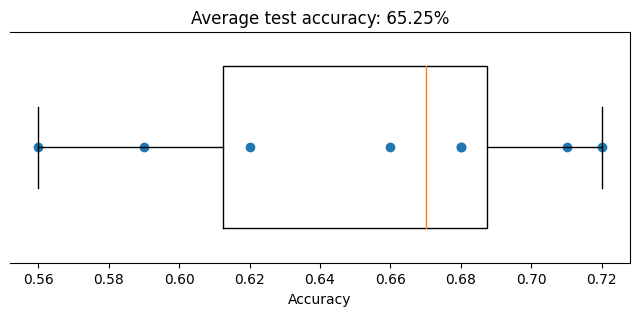

In [ ]:
m_r = np.repeat([0, 1, 1], 400)
m_p = perception.reshape([-1])


def classifyMotionFromSpikes(spikes, classes,
                             halfwin=None,
                             motions=[0, 1, 2],
                             cv=8):
  """
    Runs one logistic regression using the specified parameters.

    Args:
        spikes (numpy.ndarray): a 4d matrix with spike counts for 1) three motion
        conditions, 2) 400 trials, 3) 40 neurons, 4) 301 time bins
        classes (list): list of length 3 * 400 with classes to use for the
        logistic regression
        halfwin: None to use the whole 3 s time interval, or a value between 0
        and 0.750 seconds as the extent of the window from 0 (when acceleration
        peaks)
        motions (list): motion conditions to include, any subset of [0,1,2]
        cv (int): number of cross validations to do in logistic regression

    Returns:
        (numpy.ndarray): 1d array of shape (cv,) with prediction accuracies for
        each cross validation

    This function uses our getDesignMatrix() function according to specification
    and then uses cross-validated logistic regression and returns the accuracy
    for each run of the model.
  """

  # get the right design matrix:
  X, y = getDesignMatrix(spikes, motions, classes=classes, halfwin=halfwin)

  # right now, we are not using regularization:
  return cross_val_score(LogisticRegression(solver='liblinear'), X=X, y=y, cv=cv)


accuracies = classifyMotionFromSpikes(spikes, m_r, motions=[0, 1])
plotCrossValAccuracies(accuracies)

This is the exact same figure as before, so our function `classifyMotionFromSpikes()` also works as intended.

----
# Model completion

*Part of step 8*

**Can we answer our question?** Question: "Does accumulated vestibular neuron activity correlate with self-motion judgements?" Yes, we can get an answer to the question by applying our analysis to predict self-motion judgements.

**Can we speak to our hypothesis?** We had two hypotheses: 1) prediction is better with total accumulated spike counts than from a window around peak acceleration, and 2) prediction is better with higher acceleration as the signal-to-noise ratio increases.

**Does the model reach our goals?** We want to understand if motion judgement and not true motion correlates better with vestibular neural activity.

Note: We have somewhat refined our goal here by explicitly contrasting true motion with motion judgements.

----
# Model evaluation & testing

*Part of step 9*

We can now evaluate the performance of our analysis pipeline.

To do so, we will run the logistic regression quite a few times: on all data or split by the velocities, and then we use the data to predict the presence of real motion, or the judgements of self-motion. We repeat this for total accumulated spikes and for a window around the peak acceleration. And then we'll plot the average classification performance in those 12 cases.

In [ ]:
def runAnalysis(spikes):
  """
    Runs one logistic regression using the specified parameters.

    Args:
        spikes (numpy.ndarray): a 4d matrix with spike counts for 1) three motion
        conditions, 2) 400 trials, 3) 40 neurons, 4) 301 time bins

    Returns:
        (numpy.ndarray): array of shape (2, 2, 3, 12), where the first dimension
        denotes full interval or 100 ms window, the second dimension denotes
        real motion or self-motion judgements, the third dimension denotes slow,
        fast or all data, and for each there 12 prediction accuracies for each
        of the 12 cross validations

    This function uses our classifyMotionFromSpikes()) function according to
    specification for all the different ways we want to classify the data and
    gives us the classification performance.
  """

  # variables we use for testing our analysis pipeline:
  m_r = np.repeat([0, 1, 1], 400)
  m_p = perception.reshape([-1])
  halfwins = [None, 0.050]
  motions = [[0, 1], [0, 2], [0, 1, 2]]
  class_sets = [m_r, m_p]
  cv = 12

  # empty array to collect classification performance:
  accuracies = np.zeros([len(halfwins), len(class_sets), len(motions), cv])

  for halfwin_no in range(len(halfwins)):

    halfwin = halfwins[halfwin_no]
    lty = ['-', '--'][halfwin_no]
    leg_hw = ['accumulated', '100 ms window'][halfwin_no]

    for classes_no in range(len(class_sets)):

      classes = class_sets[classes_no]
      leg_class = ['real', 'judgements'][classes_no]
      color = ['orange','purple'][classes_no]

      for motions_no in range(len(motions)):

        motion = motions[motions_no]
        cond_acc = classifyMotionFromSpikes(spikes = spikes,
                                            classes = classes,
                                            halfwin = halfwin,
                                            motions = motion,
                                            cv=12)
        accuracies[halfwin_no, classes_no, motions_no, :] = cond_acc

      m_acc = np.mean(accuracies[halfwin_no, classes_no, :, :], axis=1)

  return accuracies


# here we run the above function and store the output:
accuracies = runAnalysis(spikes)

We will need to plot this output, and to simplify the code, we do that in a separate function, which we write here:

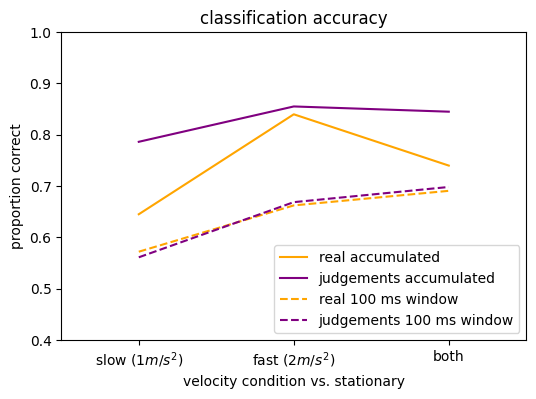

In [ ]:
def plotAccuracies(accuracies):
  """
    Plot the accuracies from our main fitting function.

    Args:
        accuarcies (numpy.ndarray): a 4d matrix with performance accuracy for
        1) full interval or 100 ms window, 2) real motion or self-motion
        judgements, 3) slow, fast or all conditions, and 4) the 12 cross
        validations

    Returns:

    This function plots the output of our data analysis pipeline and does not
    return anything.
  """
  ax = plt.figure(figsize=(6, 4))
  plt.title('classification accuracy')
  plt.xlim([0.5, 3.5])
  plt.ylim([0.4, 1.0])
  plt.ylabel('proportion correct')
  plt.xlabel('velocity condition vs. stationary')

  for halfwin_no in range(2):

    lty = ['-', '--'][halfwin_no]
    leg_hw = ['accumulated', '100 ms window'][halfwin_no]

    for classes_no in range(2):

      leg_class = ['real', 'judgements'][classes_no]
      color = ['orange','purple'][classes_no]

      m_acc = np.mean(accuracies[halfwin_no,classes_no, :, :], axis=1)
      plt.plot([1, 2, 3], m_acc, lty, color=color,
               label=f"{leg_class} {leg_hw}")

  plt.xticks(ticks=[1, 2, 3],
             labels=['slow ($1 m/s^2$)','fast ($2 m/s^2$)','both'])
  plt.legend(loc='lower right')
  plt.show()


plotAccuracies(accuracies)

Well, that's interesting! The logistic regression doesn't do a perfect job, but there is information in these results.

1. The dashed lines reflect predictions based on a small window of data, and they do worse than the full data set: this could mean that the brain also integrates signals across longer time frames for perception.

2. In the predictions based on accumulated spike counts, the slow movements are harder to separate from no movements than the faster movements. This is clearer when predicting real motion than when predicting self-motion judgements.

Those were our two hypotheses, but we notice something else:

3. Self-motion judgments display higher decoding accuracy than the actual motion.

Actually, if self-motion judgements and our logistic regression use input from the same noisy sensors, it kind of makes sense that they would both give similar output. This is in line the notion that self-motion judgements can be wrong because the underlying sensory signals are noisy. Of course, this only works if we record activity from neuronal populations that contribute to self-motion judgements. On the other hand, we would also see this result if the sensory signal was not noisy and we recorded from one of several populations that contribute to self-motion judgements in a noisy way. So we need to do more research here.

Either way, we learned something today!

----
# Summary
*Part of Step 10*

Let's write a simple abstract following the guidelines.

**A. What is the phenomena?** Here summarize the part of the phenomena which your model addresses.

_When sitting in a stationary train and seeing the train next to them move, people may experience the "train illusion": they feel like they are moving when they are not, or vice versa. Vestibular information can disambiguate self motion from motion of the adjacent train._

**B. What is the key scientific question?** Clearly articulate the question which your model tries to answer.

_However, it is unknown if accumulated, noisy vestibular neuron activity correlates with self-motion judgement._

**C. What was our hypothesis?** Explain the key relationships which we relied on to simulate the phenomena.

_Based on previous modeling efforts, we hypothesized that cumulative spike counts (not instantaneous) recorded from vestibular neurons can better discriminate experienced self motion judgements as opposed to true self motion._

**D. How did your model work?** Give an overview of the model, it's main components, and how the model works. "Here we ..."

_Here we use logistic regression to classify both true self motion and experienced self motion judgements from vestibular neuron activity. This was done both with the vestibular signal accumulated across the full trial and with a 100 ms window ('instantaneous') around peak acceleration, and with 2 different speeds compared to a no-motion condition._

**E. What did we find?** Did the model work? Explain the key outcomes of your model evaluation.

_Decoding performance for accumulated vestibular signals was higher than for instantaneous signals. Further, experienced self motion judgements could be classified better than true self motion._

**F. What can we conclude?** Conclude as much as you can with reference to the hypothesis, within the limits of the model.

_We conclude that accumulated, noisy vestibular signals during slowly-accelerating self motion may drive the train illusion._

**G. What are the limitations and future directions?** What is left to be learned? Briefly argue the plausibility of the approach and/or what you think is essential that may have been left out.

_Future research should examine how visual signals may combine with vestibular signals in real-world scenarios to causally link these sensory signals to self-motion experience and illusions._


If we put this all in one paragraph, we have our final complete abstract. But, first, do not include the letters in _your_ abstract, and second, we did paraphrase the answers a little so they fit together.

<br>
**Abstract**

(A) When sitting in a stationary train and seeing the train next to them move, people may experience the "train illusion": they feel like they are moving when they are not, or vice versa. Vestibular information can disambiguate self motion from motion of the adjacent train. (B) However, it is unknown if accumulated, noisy vestibular neuron activity correlates with self-motion judgement. (C) Based on previous modeling efforts, we hypothesized that cumulative spike counts (not instantaneous) recorded from vestibular neurons can better discriminate experienced self motion judgements as opposed to true self motion. (D) Here we use logistic regression to classify both true self motion and experienced self motion judgements from vestibular neuron activity. This was done both with the vestibular signal accumulated across the full trial and with a 100 ms window (instantaneous) around peak acceleration, and with 2 different speeds compared to a no-motion condition. (E) Decoding performance for accumulated vestibular signals was higher than for instantaneous signals. Further, experienced self motion judgements could be classified better than true self motion. (F) We conclude that accumulated, noisy vestibular signals during slowly-accelerating self motion may drive the train illusion. (G) Future research should model possible mechanisms by which visual signals may combine with vestibular signals to causally link these sensory signals to self-motion experience and illusions.

----
# Final thoughts

Note that the analysis pipeline we built here was extremely simple and we used artificial data on purpose. It allowed us to go through all the steps of building a data neuroscience project, and hopefully you noticed that it is not always a linear process, you will go back to different steps if you hit a roadblock somewhere.

There are many issues that we did not address, such as:
* we could have tried different decoders
* or find the optimal window
* what if we had more data...
* how do different neurons contribute to the decision? And why?
  * this is something that you want to explore as a neuroscientist
* we could have run a GLM on the neurons*time array and then analyze the weightings to see if all acceleration steps are weighted equally (perfect integration)... or not?
* what is the role of visual motion in this phenomenon?

However, this project is not meant to be complete, and yours doesn't have to be either. The goal of the projects is to go through _the process_ of a modeling or data science project and put into practice one or more of the toolkits you learn at NMA with your group.
